In [1]:
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
x_train = np.load("trainX_ct.npy")
y_train = np.load("trainY_ct.npy")
x_test = np.load("testX_ct.npy")
y_test = np.load("testY_ct.npy")

### Tuning parameters

In [3]:
clf = SGDClassifier()
parameter_grid = {"alpha": (1e-4, 1), "epsilon": (0.01, 0.1)}
x_train_tune, x_test_tune, y_train_tune, y_test_tune = train_test_split(x_train, y_train, test_size=.2, random_state=29)

In [4]:
tune_search = TuneSearchCV(
    clf,
    parameter_grid,
    search_optimization="bayesian",
    n_trials=10,
    early_stopping="ASHAScheduler",
    max_iters=3,
    local_dir='.',
    return_train_score=True,
    verbose=1
)
tune_search.fit(x_train_tune, y_train_tune)

TuneSearchCV(early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f5457e17d50>,
             estimator=SGDClassifier(), local_dir='.',
             loggers=[<class 'ray.tune.logger.JsonLogger'>,
                      <class 'ray.tune.logger.CSVLogger'>],
             max_iters=3, n_jobs=-1,
             param_distributions={'alpha': (0.0001, 1), 'epsilon': (0.01, 0.1)},
             return_train_score=True,
             scoring={'score': <function _passthrough_scorer at 0x7f5459ca7290>},
             search_optimization='bayesian', sk_n_jobs=1, verbose=1)

In [5]:
print(tune_search.best_params_)

{'alpha': 0.8188281296833965, 'epsilon': 0.09175753427747863}


In [6]:
# best classifier
clf = SGDClassifier(**tune_search.best_params_)
clf.fit(x_train_tune, y_train_tune)
clf.score(x_test_tune, y_test_tune)

0.5600378190986448

### Training local models

In [29]:
def tuning(learners, local_ds, theta, theta_dist):
    global_predictions = []
    global_dist = []
    for learner in learners:
        global_predictions.append(learner.predict(global_set_x))
        global_dist.append(learner.decision_function(global_set_x).max(axis=1))
    global_predictions = np.array(global_predictions)
    
    certain_global_x = []
    certain_global_predictions = []
    correct_count = 0
    for i in range(len(global_set_x)):
        tmp = np.zeros(n_classes)
        tmp_dist = np.zeros(n_classes)
        for ind, pred in enumerate(global_predictions[:, i]):
            tmp[pred] += 1
            tmp_dist[pred] += abs(global_dist[ind][i])
        if tmp.max() >= theta and tmp_dist[tmp.argmax()] <= theta_dist:
            certain_global_x.append(global_set_x[i])
            certain_global_predictions.append(np.argmax(tmp))
            if np.argmax(tmp) == global_set_y[i]:
                correct_count += 1
    print("Certain predictions amount", len(certain_global_predictions), "with correct in them", correct_count)
    
    learners = []
    acc = 0
    for i in range(n_learners):
        clf = SGDClassifier(**tune_search.best_params_)
        if len(certain_global_x) > 0:
            local_X = np.vstack([local_set_x[i*local_ds:(i+1)*local_ds], certain_global_x])
            local_Y = np.hstack([local_set_y[i*local_ds:(i+1)*local_ds], certain_global_predictions])
        else:
            local_X = local_set_x[i*local_ds:(i+1)*local_ds]
            local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    #print("Average accuracy of local workers", acc/n_learners)
        
    return learners, acc/len(learners)

In [8]:
print("Data size", len(x_train))
n_classes = len(np.unique(y_train))

Data size 47594


In [33]:
# unlabeled examples
m = 40000
global_set_x = x_train[:m]
global_set_y = y_train[:m]
# labeled examples
local_set_x = x_train[m:]
local_set_y = y_train[m:]
n = len(x_train) - m
n_learners = 5
theta = 4
theta_dist = 4*1.0
local_ds = n//n_learners
print("Length of the local dataset", local_ds)

Length of the local dataset 1518


In [34]:
learners = []
acc = 0
for i in range(n_learners):
    clf = SGDClassifier(**tune_search.best_params_)
    local_X = local_set_x[i*local_ds:(i+1)*local_ds]
    local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
    #print(Counter(local_Y))
    clf.fit(local_X, local_Y)
    acc += clf.score(x_test, y_test)
    learners.append(clf)
print("Average accuracy of local workers", acc/n_learners)

Average accuracy of local workers 0.5770737036725775


In [35]:
for i in range(5):
    learners, acc = tuning(learners, local_ds, theta, theta_dist)

Certain predictions amount 5747 with correct in them 2726
Certain predictions amount 4798 with correct in them 1550
Certain predictions amount 0 with correct in them 0
Certain predictions amount 7069 with correct in them 3189
Certain predictions amount 5055 with correct in them 2384


### Tuning local dataset size

In [45]:
local_ds_options = [100,300,500,800,900,1000,1500]
theta = 4
theta_dist = 4*1.0
accuracies = []
for local_ds in local_ds_options:
    print("Local dataset size", local_ds)
    accuracies.append([])
    learners = []
    acc = 0
    for i in range(n_learners):
        clf = SGDClassifier(**tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    accuracies[-1].append(acc/len(learners))
    for i in range(20):
        learners, acc = tuning(learners, local_ds, theta, theta_dist)
        accuracies[-1].append(acc)

Local dataset size 100
Certain predictions amount 7689 with correct in them 5404
Certain predictions amount 331 with correct in them 104
Certain predictions amount 0 with correct in them 0
Certain predictions amount 14845 with correct in them 9232
Certain predictions amount 622 with correct in them 66
Certain predictions amount 21043 with correct in them 5593
Certain predictions amount 14 with correct in them 0
Certain predictions amount 8375 with correct in them 4240
Certain predictions amount 1491 with correct in them 169
Certain predictions amount 0 with correct in them 0
Certain predictions amount 8782 with correct in them 6433
Certain predictions amount 1669 with correct in them 349
Certain predictions amount 3245 with correct in them 1171
Certain predictions amount 0 with correct in them 0
Certain predictions amount 9431 with correct in them 6537
Certain predictions amount 937 with correct in them 113
Certain predictions amount 40000 with correct in them 6331
Certain predictions 

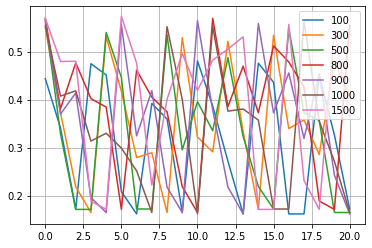

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

for ind, ld in enumerate(local_ds_options):
    accs = accuracies[ind]
    plt.plot(range(len(accs)), accs, label=str(ld))
plt.legend()
plt.show()

### Tuning theta

In [239]:
local_ds = 110
theta_options = [8,9,10,11,12,13,14,15,16,17,18,19,20]
accuracies = []
for theta in theta_options:
    print("Theta", theta)
    accuracies.append([])
    learners = []
    acc = 0
    for i in range(n_learners):
        clf = SGDClassifier(**tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    accuracies[-1].append(acc/len(learners))
    for i in range(5):
        learners, acc = tuning(learners, local_ds, theta)
        accuracies[-1].append(acc)

Theta 8
Theta 9
Theta 10
Theta 11
Theta 12
Theta 13
Theta 14
Theta 15
Theta 16
Theta 17
Theta 18
Theta 19
Theta 20


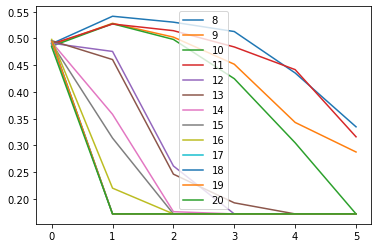

In [240]:
for ind, th in enumerate(theta_options):
    accs = accuracies[ind]
    plt.plot(range(len(accs)), accs, label=str(th))
plt.legend()
plt.show()